In [1]:
# %pip install matplotlib
# %pip install tqdm  
from torch.utils.data import DataLoader
from utils.dataset import VCTKDataset
import numpy as np
import os
from pathlib import Path
import torch
import torch.nn as nn
from src.model.cvae_tacotron_wrapper import CVAETacotron2, cvae_taco_loss
import argparse
from matplotlib import pyplot as plt
import ipywidgets
from tqdm.notebook import tqdm



In [2]:
dataset = VCTKDataset("./dataset/VCTK",)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0,
                    collate_fn=VCTKDataset.collate_cvae)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Selected speakers: ['p323', 'p301', 'p240', 'p299', 'p225', 'p285', 'p252', 'p279', 'p287', 'p311']
Speaker 0: p323: F, 19yo, SouthAfrican (Pretoria)
Speaker 1: p301: F, 23yo, American (North Carolina)
Speaker 2: p240: F, 21yo, English (Southern England)
Speaker 3: p299: F, 25yo, American (California)
Speaker 4: p225: F, 23yo, English (Southern England)
Speaker 5: p285: M, 21yo, Scottish (Edinburgh)
Speaker 6: p252: M, 22yo, Scottish (Edinburgh)
Speaker 7: p279: M, 23yo, English (Leicester)
Speaker 8: p287: M, 23yo, English (York)
Speaker 9: p311: M, 21yo, American (Iowa)
Using device: cuda


Using device: cuda


Using cache found in C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\jx/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Epoch 1/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([ 48,  60,  47,  53,  42,  30,  34,  36,  55,  65,  30,  47,  33,  37,
         31,  91,  54,  34,  55,  28,  47,  31,  31,  40,  28,  29,  24,  34,
         28,  60,  44, 159]) and mel length tensor([315, 313, 335, 292, 366, 233, 203, 292, 372, 392, 204, 335, 213, 255,
        220, 507, 460, 263, 280, 265, 258, 256, 412, 375, 181, 272, 240, 263,
        162, 450, 394, 783])
[Epoch 1/10] Loss: 0.0137 | l1: 0.0089, gate: 0.0048, kl: 0.0005


Epoch 2/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([22, 54, 62, 33, 69, 26, 61, 66, 39, 22, 20, 73, 26, 59, 15, 32, 22, 60,
        56, 44, 70, 20, 24, 23, 28, 39, 26, 51, 43, 39, 36, 27]) and mel length tensor([196, 385, 370, 265, 485, 244, 287, 353, 272, 214, 217, 436, 229, 416,
        163, 298, 180, 374, 299, 343, 352, 170, 207, 214, 210, 243, 201, 309,
        431, 292, 280, 269])
[Epoch 2/10] Loss: 0.0163 | l1: 0.0113, gate: 0.0050, kl: 0.0016


Epoch 3/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([ 34,  51,  25, 179,  44,  27,  45,  66,  44, 117,  50,  30,  50,  34,
         45,  33,  35,  30,  24,  52,  28,  32,  29,  55,  43,  26,  67,  35,
         39,  25,  33,  33]) and mel length tensor([258, 306, 181, 852, 273, 295, 270, 456, 297, 694, 321, 253, 317, 258,
        251, 258, 331, 246, 220, 271, 288, 275, 228, 306, 298, 226, 320, 296,
        276, 190, 240, 301])
[Epoch 3/10] Loss: 0.0083 | l1: 0.0066, gate: 0.0017, kl: 0.0016


Epoch 4/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([27, 26, 28, 31, 35, 91, 31, 27, 30, 34, 30, 25, 19, 46, 17, 24, 51, 15,
        65, 61, 42, 65, 40, 64, 21, 43, 42, 54, 56, 12, 64, 46]) and mel length tensor([295, 204, 322, 263, 284, 449, 299, 201, 206, 228, 273, 359, 170, 284,
        204, 188, 298, 155, 321, 304, 307, 425, 298, 339, 195, 376, 339, 310,
        565, 204, 331, 266])
[Epoch 4/10] Loss: 0.0116 | l1: 0.0090, gate: 0.0026, kl: 0.0027


Epoch 5/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([104,  65,  13,  30,  26,  54,  21,  56,  38,  47,  48,  57,  40,  64,
         24,  50,  46,  39,  29,  18,  42,  31,  25,  28,  34,  18,  61,  22,
         66,  17,  26,  11]) and mel length tensor([545, 313, 115, 237, 201, 328, 189, 277, 302, 409, 313, 326, 230, 305,
        210, 313, 401, 368, 188, 213, 263, 203, 198, 226, 269, 205, 283, 247,
        422, 167, 196, 166])
[Epoch 5/10] Loss: 0.0127 | l1: 0.0087, gate: 0.0040, kl: 0.0029


Epoch 6/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([34, 63, 45, 43, 45, 26, 27, 20, 25, 39, 36, 32, 53, 54, 88, 40, 34, 22,
        54, 32, 65, 51, 56, 31, 24, 21, 64, 47, 28, 26, 18, 33]) and mel length tensor([288, 432, 391, 284, 361, 219, 258, 190, 223, 322, 245, 251, 420, 284,
        471, 376, 314, 221, 312, 295, 313, 482, 405, 196, 181, 273, 340, 238,
        273, 256, 148, 231])
[Epoch 6/10] Loss: 0.0089 | l1: 0.0080, gate: 0.0009, kl: 0.0034


Epoch 7/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([ 27,  51,  22,  37,  50,  27,  29, 103,  36,  41,  72,  42,  38,  28,
         28,  57,  37,  30,  20,  46,  11,  20,  71,  26, 112,  40,  56,  36,
        119,  41,  32,  28]) and mel length tensor([232, 322, 276, 236, 337, 217, 221, 634, 236, 269, 502, 273, 338, 211,
        218, 287, 265, 253, 212, 243, 166, 163, 362, 187, 651, 262, 346, 280,
        640, 269, 266, 247])
[Epoch 7/10] Loss: 0.0078 | l1: 0.0072, gate: 0.0006, kl: 0.0040


Epoch 8/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([119,  41,  37,  26,  26,  43,  19,  27,  57,  62,  68,  16,  28,  26,
         44,  44,  44,  30,  23,  21,  42,  37,  32,  29,  28,  42,  35,  43,
         62,  20,  30,  33]) and mel length tensor([552, 272, 346, 183, 265, 275, 199, 177, 368, 498, 482, 170, 245, 230,
        241, 262, 287, 202, 210, 205, 361, 247, 279, 221, 206, 313, 283, 282,
        291, 240, 382, 309])
[Epoch 8/10] Loss: 0.0070 | l1: 0.0066, gate: 0.0004, kl: 0.0048


Epoch 9/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([48, 15, 64, 20, 60, 29, 28, 66, 76, 31, 38, 34, 65, 36, 40, 38, 36, 88,
        63, 41, 69, 32, 30, 17, 55, 30, 39, 33, 40, 31, 69, 36]) and mel length tensor([390, 188, 427, 148, 313, 192, 225, 432, 470, 225, 338, 256, 425, 337,
        263, 309, 258, 471, 300, 327, 408, 298, 251, 199, 351, 306, 236, 350,
        306, 330, 408, 229])
[Epoch 9/10] Loss: 0.0076 | l1: 0.0072, gate: 0.0004, kl: 0.0053


Epoch 10/10:   0%|          | 0/122 [00:00<?, ?it/s]

Processing batch with text length tensor([179,  67,  43,  52,  36,  21,  37,  31,  51,  42,  38,  41,  44,  49,
         28,  46,  45,  73,  49,  41,  21,  33,  15,  56,  26,  31,  17,  33,
         30,  16,  73,  42]) and mel length tensor([977, 379, 378, 306, 269, 185, 375, 203, 433, 306, 324, 250, 276, 327,
        225, 458, 350, 414, 236, 286, 294, 203, 140, 368, 223, 224, 179, 354,
        326, 140, 334, 419])
[Epoch 10/10] Loss: 0.0049 | l1: 0.0047, gate: 0.0002, kl: 0.0048


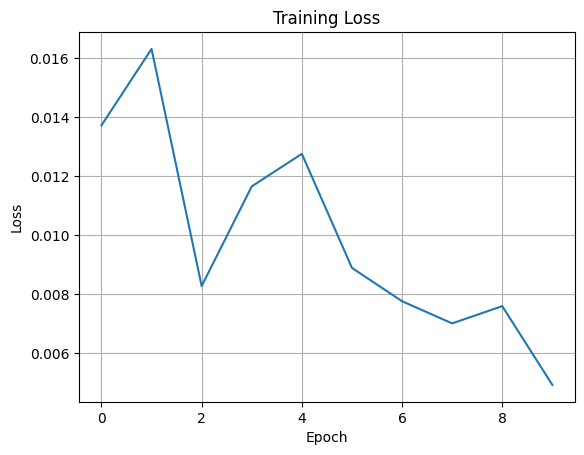

Model saved to src\model\cvae_tacotron2_trial1.pth


In [3]:
EPOCH = 10
BATCH_SIZE = 32
LR = 1e-3



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CVAETacotron2(ckpt_path="./src/model/tacotron2_pretrained.pt", z_dim=64, spk_dim_raw=256, spk_dim_proj=128)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.train()

loss_tracker = []

for epoch in range(EPOCH):
    loss_sum = 0
    logsum = {'l1': 0, 'gate': 0, 'kl': 0}

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCH}", leave=False, position=0, dynamic_ncols=True)

    for text, text_len, mel, mel_len, gate, spk_id in pbar:
        print(f"Processing batch with text length {text_len} and mel length {mel_len}")
        text, text_len = text.to(device), text_len.to(device)
        mel, gate = mel.to(device), gate.to(device)
        spk_emd = model.spk_emb[spk_id].to(device)

        mel_post, mel_out, gate_out, mu, logvar = model(text, text_len, mel, spk_emd)
        loss, logs = cvae_taco_loss(mel_post, mel, gate_out, gate, mu, logvar)        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        logsum['l1'] += logs['l1']
        logsum['gate'] += logs['gate']
        logsum['kl'] += logs['kl']

        pbar.set_postfix(loss=loss.item(), l1=logs['l1'], gate=logs['gate'], kl=logs['kl'])
        break

    loss_avg = loss_sum / len(dataloader)
    loss_tracker.append(loss_avg)
    print(f"[Epoch {epoch+1}/{EPOCH}] Loss: {loss_avg:.4f} | l1: {logsum['l1'] / len(dataloader):.4f}, gate: {logsum['gate'] / len(dataloader):.4f}, kl: {logsum['kl'] / len(dataloader):.4f}")

plt.plot(loss_tracker)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.show()

model_save_path = Path("./src/model/cvae_tacotron2_trial1.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [4]:

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
text, text_len, mel, mel_len, gate, spk_id = next(iter(dataloader))
text, text_len = text.to(device), text_len.to(device)
mel, gate = mel.to(device), gate.to(device)
spk_emd = model.spk_emb[spk_id].to(device)
mel_post, mel_out, gate_out, mu, logvar = model(text, text_len, mel, spk_emd)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel_post[0].cpu().detach().numpy(), aspect='auto', origin='lower')
plt.title('Mel Post')
plt.subplot(1, 2, 2)



    

ValueError: not enough values to unpack (expected 6, got 3)